In [1]:
"""
TorchVision Object Detection Finetuning Tutorial
====================================================
"""

'\nTorchVision Object Detection Finetuning Tutorial\n====================================================\n'


#####################################################################

.. tip::

    To get the most of this tutorial, we suggest using this
    `Colab Version <https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb>`__.
    This will allow you to experiment with the information presented below.


For this tutorial, we will be finetuning a pre-trained `Mask
R-CNN <https://arxiv.org/abs/1703.06870>`__ model on the `Penn-Fudan
Database for Pedestrian Detection and
Segmentation <https://www.cis.upenn.edu/~jshi/ped_html/>`__. It contains
170 images with 345 instances of pedestrians, and we will use it to
illustrate how to use the new features in torchvision in order to train
an object detection and instance segmentation model on a custom dataset.


.. note ::

    This tutorial works only with torchvision version >=0.16 or nightly.
    If you're using torchvision<=0.15, please follow
    `this tutorial instead <https://github.com/pytorch/tutorials/blob/d686b662932a380a58b7683425faa00c06bcf502/intermediate_source/torchvision_tutorial.rst>`_.


Defining the Dataset
--------------------

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
``torch.utils.data.Dataset`` class, and implement ``__len__`` and
``__getitem__``.

The only specificity that we require is that the dataset ``__getitem__``
should return a tuple:

-  image: :class:`torchvision.tv_tensors.Image` of shape ``[3, H, W]``, a pure tensor, or a PIL Image of size ``(H, W)``
-  target: a dict containing the following fields

   -  ``boxes``, :class:`torchvision.tv_tensors.BoundingBoxes` of shape ``[N, 4]``:
      the coordinates of the ``N`` bounding boxes in ``[x0, y0, x1, y1]`` format, ranging from ``0``
      to ``W`` and ``0`` to ``H``
   -  ``labels``, integer :class:`torch.Tensor` of shape ``[N]``: the label for each bounding box.
      ``0`` represents always the background class.
   -  ``image_id``, int: an image identifier. It should be
      unique between all the images in the dataset, and is used during
      evaluation
   -  ``area``, float :class:`torch.Tensor` of shape ``[N]``: the area of the bounding box. This is used
      during evaluation with the COCO metric, to separate the metric
      scores between small, medium and large boxes.
   -  ``iscrowd``, uint8 :class:`torch.Tensor` of shape ``[N]``: instances with ``iscrowd=True`` will be
      ignored during evaluation.
   -  (optionally) ``masks``, :class:`torchvision.tv_tensors.Mask` of shape ``[N, H, W]``: the segmentation
      masks for each one of the objects

If your dataset is compliant with above requirements then it will work for both
training and evaluation codes from the reference script. Evaluation code will use scripts from
``pycocotools`` which can be installed with ``pip install pycocotools``.

.. note ::
  For Windows, please install ``pycocotools`` from `gautamchitnis <https://github.com/gautamchitnis/cocoapi>`__ with command

  ``pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI``

One note on the ``labels``. The model considers class ``0`` as background. If your dataset does not contain the background class,
you should not have ``0`` in your ``labels``. For example, assuming you have just two classes, *cat* and *dog*, you can
define ``1`` (not ``0``) to represent *cats* and ``2`` to represent *dogs*. So, for instance, if one of the images has both
classes, your ``labels`` tensor should look like ``[1, 2]``.

Additionally, if you want to use aspect ratio grouping during training
(so that each batch only contains images with similar aspect ratios),
then it is recommended to also implement a ``get_height_and_width``
method, which returns the height and the width of the image. If this
method is not provided, we query all elements of the dataset via
``__getitem__`` , which loads the image in memory and is slower than if
a custom method is provided.

Writing a custom dataset for PennFudan
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Let’s write a dataset for the PennFudan dataset. After `downloading and
extracting the zip
file <https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip>`__, we
have the following folder structure:

::

   PennFudanPed/
     PedMasks/
       FudanPed00001_mask.png
       FudanPed00002_mask.png
       FudanPed00003_mask.png
       FudanPed00004_mask.png
       ...
     PNGImages/
       FudanPed00001.png
       FudanPed00002.png
       FudanPed00003.png
       FudanPed00004.png

Here is one example of a pair of images and segmentation masks

.. image:: ../../_static/img/tv_tutorial/tv_image01.png

.. image:: ../../_static/img/tv_tutorial/tv_image02.png

So each image has a corresponding
segmentation mask, where each color correspond to a different instance.
Let’s write a :class:`torch.utils.data.Dataset` class for this dataset.
In the code below, we are wrapping images, bounding boxes and masks into
``torchvision.TVTensor`` classes so that we will be able to apply torchvision
built-in transformations (`new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_)
for the given object detection and segmentation task.
Namely, image tensors will be wrapped by :class:`torchvision.tv_tensors.Image`, bounding boxes into
:class:`torchvision.tv_tensors.BoundingBoxes` and masks into :class:`torchvision.tv_tensors.Mask`.
As ``torchvision.TVTensor`` are :class:`torch.Tensor` subclasses, wrapped objects are also tensors and inherit the plain
:class:`torch.Tensor` API. For more information about torchvision ``tv_tensors`` see
`this documentation <https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors>`_.

In [2]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
        

######################################################################
# That’s all for the dataset. Now let’s define a model that can perform
# predictions on this dataset.
#
# Defining your model
# -------------------
#
# In this tutorial, we will be using `Mask
# R-CNN <https://arxiv.org/abs/1703.06870>`__, which is based on top of
# `Faster R-CNN <https://arxiv.org/abs/1506.01497>`__. Faster R-CNN is a
# model that predicts both bounding boxes and class scores for potential
# objects in the image.
#
# .. image:: ../../_static/img/tv_tutorial/tv_image03.png
#
# Mask R-CNN adds an extra branch
# into Faster R-CNN, which also predicts segmentation masks for each
# instance.
#
# .. image:: ../../_static/img/tv_tutorial/tv_image04.png
#
# There are two common
# situations where one might want
# to modify one of the available models in TorchVision Model Zoo. The first
# is when we want to start from a pre-trained model, and just finetune the
# last layer. The other is when we want to replace the backbone of the
# model with a different one (for faster predictions, for example).
#
# Let’s go see how we would do one or another in the following sections.
#
# 1 - Finetuning from a pretrained model
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Let’s suppose that you want to start from a model pre-trained on COCO
# and want to finetune it for your particular classes. Here is a possible
# way of doing it:


import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

######################################################################
# 2 - Modifying the model to add a different backbone
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

######################################################################
# Object detection and instance segmentation model for PennFudan Dataset
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# In our case, we want to finetune from a pre-trained model, given that
# our dataset is very small, so we will be following approach number 1.
#
# Here we want to also compute the instance segmentation masks, so we will
# be using Mask R-CNN:


import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model


######################################################################
# That’s it, this will make ``model`` be ready to be trained and evaluated
# on your custom dataset.
#
# Putting everything together
# ---------------------------
#
# In ``references/detection/``, we have a number of helper functions to
# simplify training and evaluating detection models. Here, we will use
# ``references/detection/engine.py`` and ``references/detection/utils.py``.
# Just download everything under ``references/detection`` to your folder and use them here.
# On Linux if you have ``wget``, you can download them using below commands:

os.system("""
mkdir -p lib;
cd lib;
wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py;
wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py;
wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py;
wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py;
wget -nc https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py;
""")

File ‘utils.py’ already there; not retrieving.

File ‘transforms.py’ already there; not retrieving.

File ‘coco_eval.py’ already there; not retrieving.

File ‘engine.py’ already there; not retrieving.

File ‘coco_utils.py’ already there; not retrieving.



0

In [3]:

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import lib.utils as utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.2096, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0557, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0606, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0034, grad_fn=<DivBackward0>)}


{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [4]:

######################################################################
# Let’s now write the main function which performs the training and the
# validation:


from lib.engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [5]:
# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:08:25  lr: 0.000090  loss: 4.1577 (4.1577)  loss_classifier: 0.8319 (0.8319)  loss_box_reg: 0.2384 (0.2384)  loss_mask: 3.0339 (3.0339)  loss_objectness: 0.0520 (0.0520)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 8.4325  data: 0.4739  max mem: 2070


Epoch: [0]  [10/60]  eta: 0:00:54  lr: 0.000936  loss: 1.9414 (2.3821)  loss_classifier: 0.5209 (0.5125)  loss_box_reg: 0.3122 (0.3283)  loss_mask: 1.1730 (1.5063)  loss_objectness: 0.0226 (0.0292)  loss_rpn_box_reg: 0.0035 (0.0058)  time: 1.0986  data: 0.0509  max mem: 2762


Epoch: [0]  [20/60]  eta: 0:00:29  lr: 0.001783  loss: 0.8739 (1.5545)  loss_classifier: 0.2157 (0.3405)  loss_box_reg: 0.2520 (0.2749)  loss_mask: 0.3844 (0.9078)  loss_objectness: 0.0195 (0.0255)  loss_rpn_box_reg: 0.0055 (0.0058)  time: 0.3485  data: 0.0093  max mem: 2762


Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.002629  loss: 0.6382 (1.2443)  loss_classifier: 0.1190 (0.2600)  loss_box_reg: 0.2148 (0.2735)  loss_mask: 0.2256 (0.6845)  loss_objectness: 0.0073 (0.0199)  loss_rpn_box_reg: 0.0063 (0.0063)  time: 0.2946  data: 0.0087  max mem: 2788


Epoch: [0]  [40/60]  eta: 0:00:10  lr: 0.003476  loss: 0.5388 (1.0728)  loss_classifier: 0.0754 (0.2137)  loss_box_reg: 0.2545 (0.2679)  loss_mask: 0.2041 (0.5679)  loss_objectness: 0.0037 (0.0160)  loss_rpn_box_reg: 0.0074 (0.0073)  time: 0.2832  data: 0.0077  max mem: 3318


Epoch: [0]  [50/60]  eta: 0:00:04  lr: 0.004323  loss: 0.4380 (0.9435)  loss_classifier: 0.0472 (0.1801)  loss_box_reg: 0.1706 (0.2449)  loss_mask: 0.1911 (0.4980)  loss_objectness: 0.0021 (0.0135)  loss_rpn_box_reg: 0.0055 (0.0071)  time: 0.2953  data: 0.0081  max mem: 3318


Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.3838 (0.8559)  loss_classifier: 0.0439 (0.1609)  loss_box_reg: 0.1508 (0.2289)  loss_mask: 0.1696 (0.4473)  loss_objectness: 0.0017 (0.0122)  loss_rpn_box_reg: 0.0045 (0.0067)  time: 0.2955  data: 0.0081  max mem: 3704
Epoch: [0] Total time: 0:00:26 (0.4472 s / it)


creating index...
index created!


Test:  [ 0/50]  eta: 0:00:35  model_time: 0.2779 (0.2779)  evaluator_time: 0.0074 (0.0074)  time: 0.7085  data: 0.4184  max mem: 3704


Test:  [49/50]  eta: 0:00:00  model_time: 0.0514 (0.1142)  evaluator_time: 0.0057 (0.0086)  time: 0.0859  data: 0.0037  max mem: 3704
Test: Total time: 0:00:06 (0.1398 s / it)
Averaged stats: model_time: 0.0514 (0.1142)  evaluator_time: 0.0057 (0.0086)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 

Epoch: [1]  [ 0/60]  eta: 0:00:41  lr: 0.005000  loss: 0.6595 (0.6595)  loss_classifier: 0.1059 (0.1059)  loss_box_reg: 0.3536 (0.3536)  loss_mask: 0.1863 (0.1863)  loss_objectness: 0.0027 (0.0027)  loss_rpn_box_reg: 0.0109 (0.0109)  time: 0.6950  data: 0.4511  max mem: 3704


Epoch: [1]  [10/60]  eta: 0:00:16  lr: 0.005000  loss: 0.2669 (0.3078)  loss_classifier: 0.0348 (0.0404)  loss_box_reg: 0.0810 (0.1140)  loss_mask: 0.1390 (0.1456)  loss_objectness: 0.0009 (0.0031)  loss_rpn_box_reg: 0.0030 (0.0046)  time: 0.3397  data: 0.0465  max mem: 3704


Epoch: [1]  [20/60]  eta: 0:00:12  lr: 0.005000  loss: 0.2867 (0.3202)  loss_classifier: 0.0444 (0.0469)  loss_box_reg: 0.0993 (0.1147)  loss_mask: 0.1397 (0.1511)  loss_objectness: 0.0010 (0.0027)  loss_rpn_box_reg: 0.0034 (0.0048)  time: 0.2915  data: 0.0078  max mem: 3704


Epoch: [1]  [30/60]  eta: 0:00:09  lr: 0.005000  loss: 0.3028 (0.3079)  loss_classifier: 0.0444 (0.0425)  loss_box_reg: 0.0993 (0.1082)  loss_mask: 0.1460 (0.1498)  loss_objectness: 0.0012 (0.0026)  loss_rpn_box_reg: 0.0046 (0.0049)  time: 0.2972  data: 0.0094  max mem: 3704


Epoch: [1]  [40/60]  eta: 0:00:06  lr: 0.005000  loss: 0.2525 (0.2930)  loss_classifier: 0.0246 (0.0398)  loss_box_reg: 0.0727 (0.1028)  loss_mask: 0.1230 (0.1431)  loss_objectness: 0.0011 (0.0024)  loss_rpn_box_reg: 0.0046 (0.0049)  time: 0.3038  data: 0.0089  max mem: 3704


Epoch: [1]  [50/60]  eta: 0:00:03  lr: 0.005000  loss: 0.2562 (0.2900)  loss_classifier: 0.0285 (0.0399)  loss_box_reg: 0.0911 (0.1004)  loss_mask: 0.1269 (0.1427)  loss_objectness: 0.0005 (0.0021)  loss_rpn_box_reg: 0.0045 (0.0050)  time: 0.2927  data: 0.0092  max mem: 3704


Epoch: [1]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.2562 (0.2843)  loss_classifier: 0.0356 (0.0396)  loss_box_reg: 0.0820 (0.0963)  loss_mask: 0.1280 (0.1412)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0045 (0.0051)  time: 0.2797  data: 0.0092  max mem: 3704
Epoch: [1] Total time: 0:00:17 (0.2982 s / it)


creating index...
index created!


Test:  [ 0/50]  eta: 0:00:19  model_time: 0.0713 (0.0713)  evaluator_time: 0.0037 (0.0037)  time: 0.3892  data: 0.3115  max mem: 3704


Test:  [49/50]  eta: 0:00:00  model_time: 0.0485 (0.0513)  evaluator_time: 0.0038 (0.0059)  time: 0.0615  data: 0.0040  max mem: 3704
Test: Total time: 0:00:03 (0.0713 s / it)
Averaged stats: model_time: 0.0485 (0.0513)  evaluator_time: 0.0038 (0.0059)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.798
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 

Epoch: [2]  [ 0/60]  eta: 0:00:42  lr: 0.005000  loss: 0.1651 (0.1651)  loss_classifier: 0.0178 (0.0178)  loss_box_reg: 0.0386 (0.0386)  loss_mask: 0.1051 (0.1051)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.7087  data: 0.4342  max mem: 3704


Epoch: [2]  [10/60]  eta: 0:00:16  lr: 0.005000  loss: 0.2061 (0.2186)  loss_classifier: 0.0302 (0.0339)  loss_box_reg: 0.0550 (0.0588)  loss_mask: 0.1218 (0.1205)  loss_objectness: 0.0011 (0.0017)  loss_rpn_box_reg: 0.0035 (0.0037)  time: 0.3274  data: 0.0480  max mem: 3704


Epoch: [2]  [20/60]  eta: 0:00:11  lr: 0.005000  loss: 0.2265 (0.2491)  loss_classifier: 0.0322 (0.0373)  loss_box_reg: 0.0693 (0.0744)  loss_mask: 0.1261 (0.1318)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0036 (0.0041)  time: 0.2768  data: 0.0090  max mem: 3704


Epoch: [2]  [30/60]  eta: 0:00:08  lr: 0.005000  loss: 0.2504 (0.2490)  loss_classifier: 0.0350 (0.0369)  loss_box_reg: 0.0757 (0.0739)  loss_mask: 0.1286 (0.1326)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0036 (0.0043)  time: 0.2606  data: 0.0084  max mem: 3704


Epoch: [2]  [40/60]  eta: 0:00:05  lr: 0.005000  loss: 0.2155 (0.2373)  loss_classifier: 0.0260 (0.0345)  loss_box_reg: 0.0559 (0.0682)  loss_mask: 0.1215 (0.1294)  loss_objectness: 0.0003 (0.0011)  loss_rpn_box_reg: 0.0036 (0.0041)  time: 0.2724  data: 0.0090  max mem: 3704


Epoch: [2]  [50/60]  eta: 0:00:02  lr: 0.005000  loss: 0.2071 (0.2406)  loss_classifier: 0.0231 (0.0340)  loss_box_reg: 0.0394 (0.0683)  loss_mask: 0.1244 (0.1328)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 0.2788  data: 0.0100  max mem: 3704


Epoch: [2]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.1991 (0.2321)  loss_classifier: 0.0243 (0.0327)  loss_box_reg: 0.0394 (0.0642)  loss_mask: 0.1208 (0.1301)  loss_objectness: 0.0003 (0.0011)  loss_rpn_box_reg: 0.0032 (0.0040)  time: 0.2716  data: 0.0098  max mem: 3704
Epoch: [2] Total time: 0:00:17 (0.2839 s / it)


creating index...
index created!


Test:  [ 0/50]  eta: 0:00:21  model_time: 0.0890 (0.0890)  evaluator_time: 0.0069 (0.0069)  time: 0.4227  data: 0.3235  max mem: 3704


Test:  [49/50]  eta: 0:00:00  model_time: 0.0485 (0.0568)  evaluator_time: 0.0037 (0.0061)  time: 0.0603  data: 0.0041  max mem: 3704
Test: Total time: 0:00:03 (0.0776 s / it)
Averaged stats: model_time: 0.0485 (0.0568)  evaluator_time: 0.0037 (0.0061)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.570
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 

Epoch: [3]  [ 0/60]  eta: 0:00:41  lr: 0.000500  loss: 0.2035 (0.2035)  loss_classifier: 0.0290 (0.0290)  loss_box_reg: 0.0563 (0.0563)  loss_mask: 0.1140 (0.1140)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.6997  data: 0.4589  max mem: 3704


Epoch: [3]  [10/60]  eta: 0:00:17  lr: 0.000500  loss: 0.2159 (0.2045)  loss_classifier: 0.0238 (0.0265)  loss_box_reg: 0.0454 (0.0437)  loss_mask: 0.1280 (0.1304)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0031 (0.0032)  time: 0.3410  data: 0.0499  max mem: 3704


Epoch: [3]  [20/60]  eta: 0:00:12  lr: 0.000500  loss: 0.1969 (0.1945)  loss_classifier: 0.0238 (0.0264)  loss_box_reg: 0.0432 (0.0409)  loss_mask: 0.1183 (0.1234)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0027 (0.0029)  time: 0.2974  data: 0.0095  max mem: 3704


Epoch: [3]  [30/60]  eta: 0:00:09  lr: 0.000500  loss: 0.1907 (0.2024)  loss_classifier: 0.0309 (0.0292)  loss_box_reg: 0.0425 (0.0450)  loss_mask: 0.1178 (0.1242)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0028 (0.0033)  time: 0.2786  data: 0.0095  max mem: 3704


Epoch: [3]  [40/60]  eta: 0:00:06  lr: 0.000500  loss: 0.1847 (0.1975)  loss_classifier: 0.0285 (0.0282)  loss_box_reg: 0.0362 (0.0439)  loss_mask: 0.1131 (0.1215)  loss_objectness: 0.0004 (0.0007)  loss_rpn_box_reg: 0.0027 (0.0032)  time: 0.2839  data: 0.0099  max mem: 3784


Epoch: [3]  [50/60]  eta: 0:00:02  lr: 0.000500  loss: 0.1697 (0.1966)  loss_classifier: 0.0275 (0.0283)  loss_box_reg: 0.0302 (0.0440)  loss_mask: 0.1117 (0.1203)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0020 (0.0032)  time: 0.2959  data: 0.0106  max mem: 3784


Epoch: [3]  [59/60]  eta: 0:00:00  lr: 0.000500  loss: 0.1697 (0.1935)  loss_classifier: 0.0216 (0.0274)  loss_box_reg: 0.0408 (0.0429)  loss_mask: 0.1105 (0.1191)  loss_objectness: 0.0003 (0.0009)  loss_rpn_box_reg: 0.0022 (0.0032)  time: 0.2816  data: 0.0102  max mem: 3784
Epoch: [3] Total time: 0:00:17 (0.2971 s / it)


creating index...
index created!


Test:  [ 0/50]  eta: 0:00:22  model_time: 0.1008 (0.1008)  evaluator_time: 0.0057 (0.0057)  time: 0.4575  data: 0.3454  max mem: 3784


Test:  [49/50]  eta: 0:00:00  model_time: 0.0520 (0.0550)  evaluator_time: 0.0036 (0.0054)  time: 0.0633  data: 0.0040  max mem: 3784
Test: Total time: 0:00:03 (0.0760 s / it)
Averaged stats: model_time: 0.0520 (0.0550)  evaluator_time: 0.0036 (0.0054)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.609
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.828
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 

Epoch: [4]  [ 0/60]  eta: 0:00:55  lr: 0.000500  loss: 0.2273 (0.2273)  loss_classifier: 0.0371 (0.0371)  loss_box_reg: 0.0703 (0.0703)  loss_mask: 0.1159 (0.1159)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 0.9333  data: 0.4429  max mem: 3784


Epoch: [4]  [10/60]  eta: 0:00:15  lr: 0.000500  loss: 0.1722 (0.1809)  loss_classifier: 0.0255 (0.0272)  loss_box_reg: 0.0401 (0.0410)  loss_mask: 0.1081 (0.1084)  loss_objectness: 0.0003 (0.0013)  loss_rpn_box_reg: 0.0028 (0.0030)  time: 0.3150  data: 0.0483  max mem: 3784


Epoch: [4]  [20/60]  eta: 0:00:11  lr: 0.000500  loss: 0.1636 (0.1761)  loss_classifier: 0.0192 (0.0243)  loss_box_reg: 0.0317 (0.0370)  loss_mask: 0.1058 (0.1112)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0020 (0.0027)  time: 0.2519  data: 0.0084  max mem: 3784


Epoch: [4]  [30/60]  eta: 0:00:08  lr: 0.000500  loss: 0.1516 (0.1722)  loss_classifier: 0.0191 (0.0235)  loss_box_reg: 0.0288 (0.0353)  loss_mask: 0.1058 (0.1100)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0020 (0.0025)  time: 0.2556  data: 0.0092  max mem: 3784


Epoch: [4]  [40/60]  eta: 0:00:05  lr: 0.000500  loss: 0.1741 (0.1838)  loss_classifier: 0.0261 (0.0264)  loss_box_reg: 0.0324 (0.0402)  loss_mask: 0.1098 (0.1132)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0024 (0.0028)  time: 0.2602  data: 0.0104  max mem: 3784


Epoch: [4]  [50/60]  eta: 0:00:02  lr: 0.000500  loss: 0.2074 (0.1891)  loss_classifier: 0.0314 (0.0283)  loss_box_reg: 0.0417 (0.0410)  loss_mask: 0.1218 (0.1154)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0035 (0.0029)  time: 0.2776  data: 0.0099  max mem: 3784


Epoch: [4]  [59/60]  eta: 0:00:00  lr: 0.000500  loss: 0.1986 (0.1890)  loss_classifier: 0.0282 (0.0276)  loss_box_reg: 0.0340 (0.0409)  loss_mask: 0.1218 (0.1166)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0019 (0.0028)  time: 0.2854  data: 0.0098  max mem: 3784
Epoch: [4] Total time: 0:00:16 (0.2794 s / it)


creating index...
index created!


Test:  [ 0/50]  eta: 0:00:22  model_time: 0.1008 (0.1008)  evaluator_time: 0.0047 (0.0047)  time: 0.4433  data: 0.3336  max mem: 3784


Test:  [49/50]  eta: 0:00:00  model_time: 0.0497 (0.0551)  evaluator_time: 0.0030 (0.0050)  time: 0.0589  data: 0.0032  max mem: 3784
Test: Total time: 0:00:03 (0.0744 s / it)
Averaged stats: model_time: 0.0497 (0.0551)  evaluator_time: 0.0030 (0.0050)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.830
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 

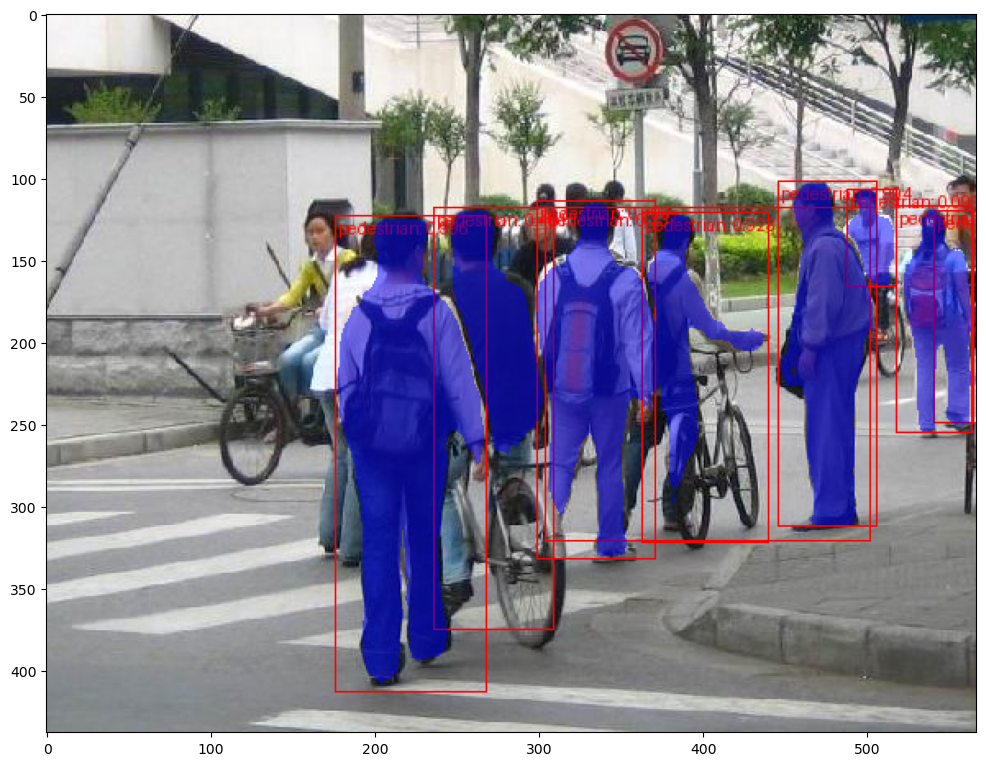

In [6]:

######################################################################
# So after one epoch of training, we obtain a COCO-style mAP > 50, and
# a mask mAP of 65.
#
# But what do the predictions look like? Let’s take one image in the
# dataset and verify
#
# .. image:: ../../_static/img/tv_tutorial/tv_image05.png
#
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("./tv_image05.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

######################################################################
# The results look good!
#
# Wrapping up
# -----------
#
# In this tutorial, you have learned how to create your own training
# pipeline for object detection models on a custom dataset. For
# that, you wrote a ``torch.utils.data.Dataset`` class that returns the
# images and the ground truth boxes and segmentation masks. You also
# leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to
# perform transfer learning on this new dataset.
#
# For a more complete example, which includes multi-machine / multi-GPU
# training, check ``references/detection/train.py``, which is present in
# the torchvision repository.
#
# You can download a full source file for this tutorial
# `here <https://pytorch.org/tutorials/_static/tv-training-code.py>`__.